CIFAR-100 데이터셋을 불러오고 전처리

In [1]:
# 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋 불러오기 (CIFAR-100)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# CIFAR-100 클래스 확인
classes = trainset.classes  # 100개의 클래스
print(f"데이터셋 클래스 수: {len(classes)}")

100%|██████████| 169M/169M [00:02<00:00, 67.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
데이터셋 클래스 수: 100


GAN의 Generator & Discriminator 정의

In [2]:
# GAN Generator 정의
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_dim=32*32*3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 3, 32, 32)

# GAN Discriminator 정의
class Discriminator(nn.Module):
    def __init__(self, img_dim=32*32*3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# 모델 초기화
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

GAN 학습 함수 구현  
손실 함수 및 최적화기 설정

In [3]:
# 손실 함수 & 옵티마이저 설정
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 학습 루프
epochs = 50
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(trainloader):

        # 실제 이미지
        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)

        # 생성된 이미지
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # 1. Discriminator 학습
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # 2. Generator 학습
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.0312483087182045 | G Loss: 3.95839262008667
[Epoch 2/50] D Loss: 0.3385658860206604 | G Loss: 4.576625347137451
[Epoch 3/50] D Loss: 0.13060562312602997 | G Loss: 6.414405822753906
[Epoch 4/50] D Loss: 0.1567942500114441 | G Loss: 4.192138671875
[Epoch 5/50] D Loss: 0.3499806523323059 | G Loss: 5.237277030944824
[Epoch 6/50] D Loss: 0.4502963423728943 | G Loss: 4.188683986663818
[Epoch 7/50] D Loss: 0.45328718423843384 | G Loss: 4.29531192779541
[Epoch 8/50] D Loss: 0.25650039315223694 | G Loss: 3.1194963455200195
[Epoch 9/50] D Loss: 0.30514901876449585 | G Loss: 2.4482803344726562
[Epoch 10/50] D Loss: 0.4196993410587311 | G Loss: 3.2819292545318604
[Epoch 11/50] D Loss: 0.3757929801940918 | G Loss: 2.2827000617980957
[Epoch 12/50] D Loss: 0.33270126581192017 | G Loss: 1.9144703149795532
[Epoch 13/50] D Loss: 0.4361807703971863 | G Loss: 2.623607635498047
[Epoch 14/50] D Loss: 0.4046451449394226 | G Loss: 2.0910370349884033
[Epoch 15/50] D Loss: 0.4574088454246

CGAN의 Generator & Discriminator 정의

In [4]:
class CGAN_Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_dim=32*32*3):
        super(CGAN_Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((z, label_input), dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), 3, 32, 32)

class CGAN_Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_dim=32*32*3):
        super(CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, img_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_input = torch.cat((img_flat, label_input), dim=1)
        return self.model(d_input)

# 모델 초기화
cgan_generator = CGAN_Generator()
cgan_discriminator = CGAN_Discriminator()

CGAN 학습 함수 구현

In [5]:
# 학습 루프
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(trainloader):

        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)

        # 랜덤 라벨 생성
        labels = labels.long()
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = cgan_generator(z, labels)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # Discriminator 학습
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(cgan_discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(cgan_discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Generator 학습
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(cgan_discriminator(fake_imgs, labels), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.69657301902771 | G Loss: 0.6991396546363831
[Epoch 2/50] D Loss: 0.6935737729072571 | G Loss: 0.7090826034545898
[Epoch 3/50] D Loss: 0.6962891221046448 | G Loss: 0.6964268088340759
[Epoch 4/50] D Loss: 0.6927885413169861 | G Loss: 0.6985443830490112
[Epoch 5/50] D Loss: 0.6951203942298889 | G Loss: 0.697318971157074
[Epoch 6/50] D Loss: 0.6930084228515625 | G Loss: 0.699169933795929
[Epoch 7/50] D Loss: 0.691137433052063 | G Loss: 0.6898835301399231
[Epoch 8/50] D Loss: 0.6923954486846924 | G Loss: 0.6944770216941833
[Epoch 9/50] D Loss: 0.6922835111618042 | G Loss: 0.6942605972290039
[Epoch 10/50] D Loss: 0.6943081021308899 | G Loss: 0.6978590488433838
[Epoch 11/50] D Loss: 0.6940343379974365 | G Loss: 0.6901092529296875
[Epoch 12/50] D Loss: 0.6955526471138 | G Loss: 0.6896504759788513
[Epoch 13/50] D Loss: 0.6946156024932861 | G Loss: 0.7026028633117676
[Epoch 14/50] D Loss: 0.6961743831634521 | G Loss: 0.6987476348876953
[Epoch 15/50] D Loss: 0.6915618181228

생성된 이미지 시각화

GAN 결과:


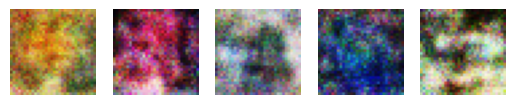

CGAN 결과 (랜덤 클래스 조건 추가):


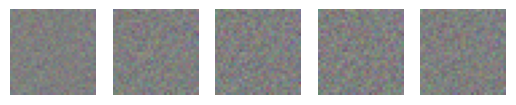

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images(generator, num_images=5, labels=None, conditional=False):
    z = torch.randn(num_images, latent_dim)

    if conditional:  # CGAN의 경우 라벨 필요
        if labels is None:
            labels = torch.randint(0, 100, (num_images,))  # CIFAR-100 클래스 중 랜덤 선택
        generated_imgs = generator(z, labels).detach().cpu().numpy()
    else:
        generated_imgs = generator(z).detach().cpu().numpy()

    # [-1, 1] 범위 → [0, 1] 범위로 정규화
    generated_imgs = (generated_imgs + 1) / 2

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.transpose(generated_imgs[i], (1,2,0)))  # 채널 변환
        plt.axis("off")
    plt.show()

print("GAN 결과:")
generate_images(generator)

print("CGAN 결과 (랜덤 클래스 조건 추가):")
generate_images(cgan_generator, conditional=True)

### GAN과 CGAN 결과 분석

#### 생성된 이미지 비교
첫 번째 이미지는 GAN과 CGAN을 이용해 생성된 이미지 결과를 보여준다.  
GAN의 경우 비교적 다양한 색상을 가진 이미지가 생성되었으나, 형태가 뚜렷하지 않으며 CIFAR-100 데이터셋의 특징을 반영하지 못하고 있다.  
반면 CGAN은 특정 클래스 조건을 추가했음에도 불구하고 생성된 이미지가 노이즈에 가까운 형태를 보이며 제대로 된 객체를 생성하지 못하고 있다.  

#### 손실값 분석
- **GAN 결과 (세 번째 이미지)**  
  - 판별자(Discriminator, D) 손실 값이 0.5~0.7 수준을 유지하며 안정적인 학습 진행됨.
  - 생성자(Generator, G) 손실 값이 1.3~1.4로 유지되며 판별자의 성능이 일정 수준으로 유지됨을 확인할 수 있음.
  - 그러나 생성된 이미지 품질이 낮아 추가적인 모델 개선이 필요함.

- **CGAN 결과 (네 번째 이미지)**  
  - 판별자 손실이 0.69 수준으로 거의 변화가 없으며, 생성자 손실 역시 0.69~0.70에서 정체됨.
  - 이는 CGAN이 제대로 학습되지 않았음을 의미하며, 학습 불안정 문제 또는 조건(Class Condition) 정보가 제대로 반영되지 않았을 가능성이 있음.
  - 생성된 이미지도 노이즈 수준에서 벗어나지 못하고 있음.

#### 개선 방안
1. **CGAN 학습 안정성 개선**  
   - 클래스 임베딩 과정 및 입력 조건이 올바르게 반영되었는지 확인.
   - 모델 아키텍처를 수정하여 학습 성능을 향상.
   - 데이터 정규화 및 학습률 조정.

2. **GAN 이미지 품질 개선**  
   - 더 깊은 네트워크 구조 사용 (예: DCGAN, StyleGAN 등).
   - 더 많은 학습 에포크 수행.
   - 배치 정규화(Batch Normalization) 및 학습률 스케줄링 적용.

이번 실험에서는 CGAN이 조건 정보를 제대로 활용하지 못해 학습이 실패한 것으로 보이며, GAN 역시 CIFAR-100의 복잡한 특성을 반영하지 못하고 있음.  
추가적인 하이퍼파라미터 튜닝과 네트워크 구조 수정이 필요할 것으로 판단됨.